# **Image Classification for Mushroom Species**

## **Loading the Datasets**

### **Import TensorFlow and other libraries**

In [1]:
# Imports needed
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Load in the dataset**

In [2]:
import pathlib
dataset_directory = pathlib.Path("E:\DL-Project\Cse499B\Training")

image_count = len(list(dataset_directory.glob('*/*.jpg')))
print(image_count)

7023


### **Some Examples of Images in the Dataset**

Glioma

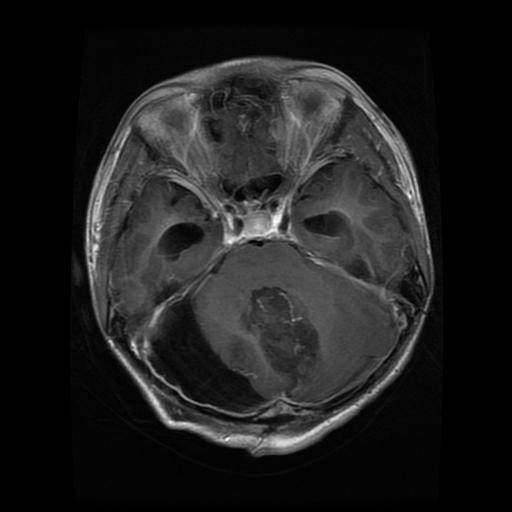

In [3]:
glioma = list(dataset_directory.glob('glioma/*'))
PIL.Image.open(str(glioma[0]))

meninglioma

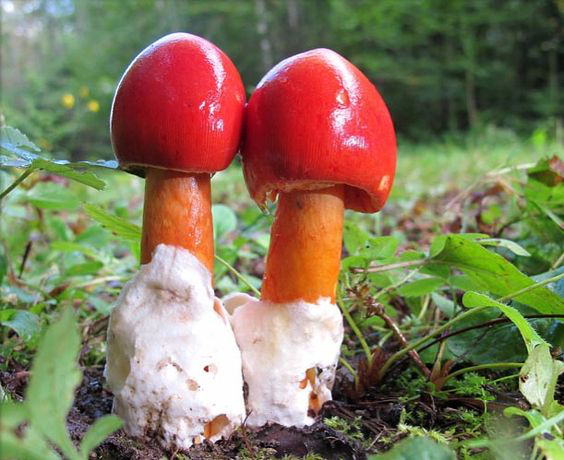

In [4]:
meninglioma = list(dataset_directory.glob('meninglioma/*'))
PIL.Image.open(str(Amanita[0]))

Suillus

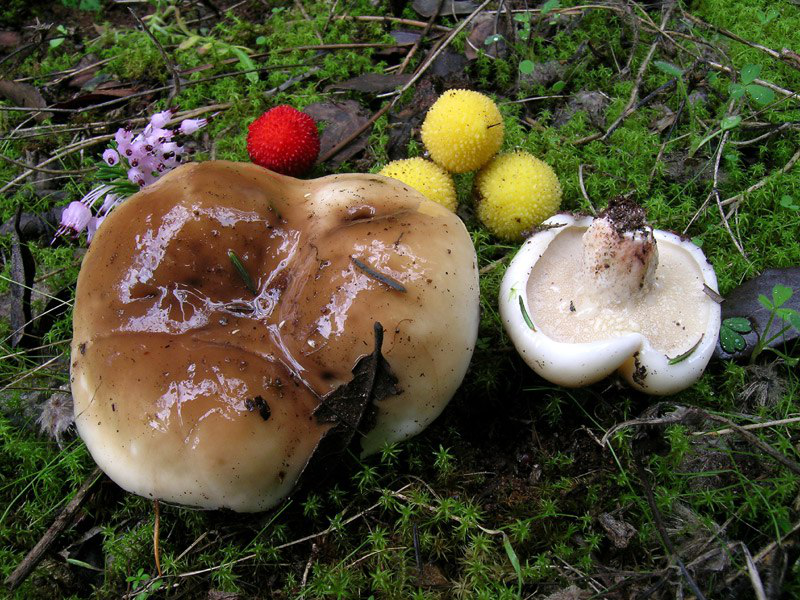

In [5]:
Suillus = list(dataset_directory.glob('Suillus/*'))
PIL.Image.open(str(Suillus[0]))

## **Load Data Using a Keras Utility**

### **Creating the Dataset**

In [6]:
batch_size = 16
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6714 files belonging to 9 classes.
Using 5372 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6714 files belonging to 9 classes.
Using 1342 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


### **Visualize the Data**

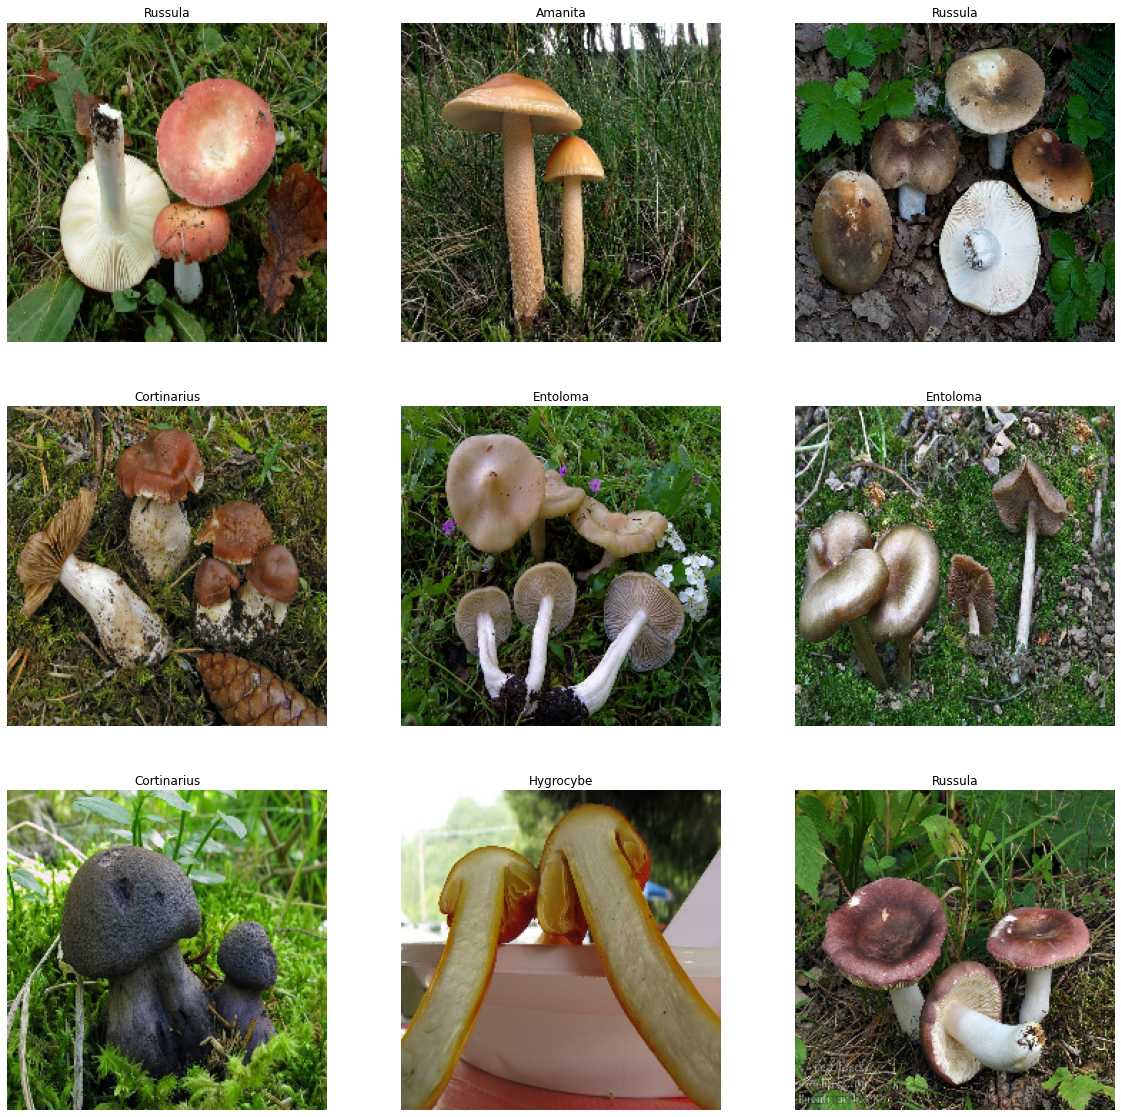

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


### **Configuring the Dataset for Performance**

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Standardize the Data**

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### **Augment the Data**

In [15]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ])

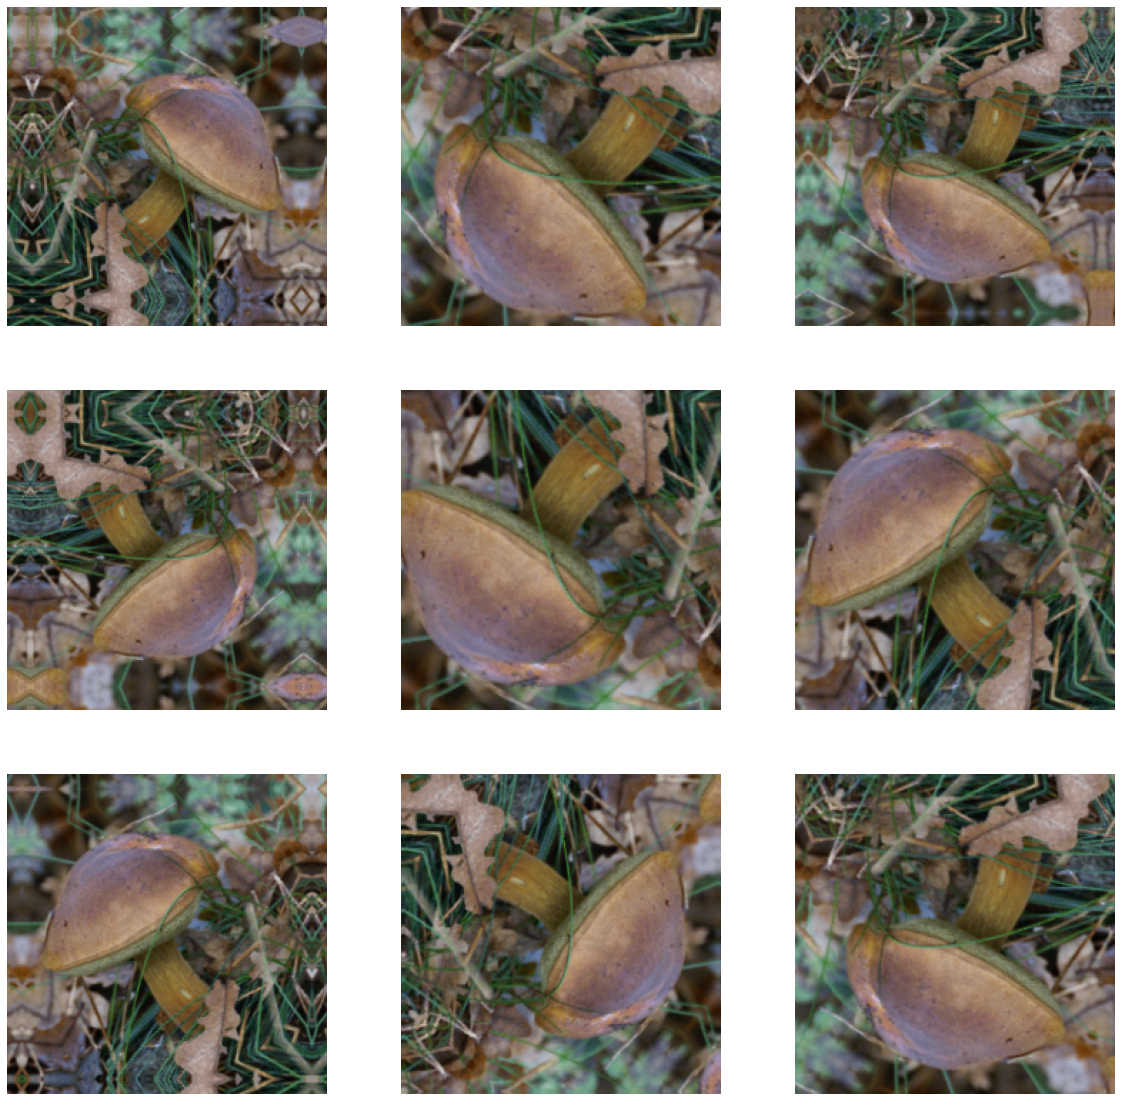

In [16]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## **Training the Model**

### **Retrieve the Model**

In [17]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = len(class_names)

resnet_model = ResNet50(weights="imagenet")

last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

model = Sequential()
model.add(data_augmentation)
model.add(resnet_layers)
model.add(Dense(num_classes))

model.layers[0].trainable=False

### **Compile the Model**

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Model Summary**

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 model (Functional)          (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 17)                34833     
                                                                 
Total params: 23,622,545
Trainable params: 23,569,425
Non-trainable params: 53,120
_________________________________________________________________


### **Define the Callback**

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model(ResNet50).h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

### **Train the Model**

In [21]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint, early, reduce_lr],
)

Epoch 1/20
170/170 [==============================] - ETA: 0s - loss: 1.2743 - accuracy: 0.6132
Epoch 1: val_accuracy improved from -inf to 0.67941, saving model to Model(ResNet50).h5
170/170 [==============================] - 979s 6s/step - loss: 1.2743 - accuracy: 0.6132 - val_loss: 1.1072 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 2/20
170/170 [==============================] - ETA: 0s - loss: 0.5298 - accuracy: 0.8279
Epoch 2: val_accuracy improved from 0.67941 to 0.68235, saving model to Model(ResNet50).h5
170/170 [==============================] - 922s 5s/step - loss: 0.5298 - accuracy: 0.8279 - val_loss: 1.2376 - val_accuracy: 0.6824 - lr: 1.0000e-04
Epoch 3/20
170/170 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8967
Epoch 3: val_accuracy improved from 0.68235 to 0.68529, saving model to Model(ResNet50).h5
170/170 [==============================] - 812s 5s/step - loss: 0.3195 - accuracy: 0.8967 - val_loss: 1.3082 - val_accuracy: 0.6853 - lr: 1.0000

### **Visualize Training Results**

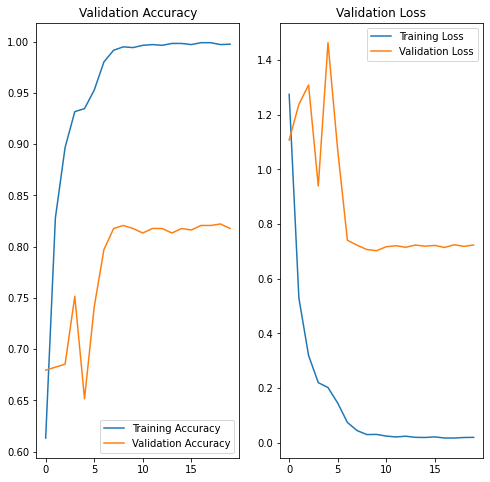

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()